In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import os

In [2]:
from pathlib import Path

# Configurable parts
SOURCE = "dukascopy"
SYMBOL = "usdjpy"
MINUTES = 1
EVENT = '58m-dollar'
START_DATE = "2020-01-01"
END_DATE = "2024-12-31"

# Build base name
RESAMPLED_NAME = f"{SOURCE}-{SYMBOL}-{MINUTES}m-{START_DATE}-{END_DATE}"
RESAMPLED_NAME = f"{SOURCE}-{SYMBOL}-{EVENT}-{START_DATE}-{END_DATE}"

# Base directories
BASE_DIR = Path("../data")
RESAMPLED_DIR = BASE_DIR / "resampled"
PROCESSED_DIR = BASE_DIR / "processed"

# Final paths
RESAMPLED_FILE_PATH = RESAMPLED_DIR / f"{RESAMPLED_NAME}.pkl"
PROCESSED_FILE_PATH = PROCESSED_DIR / f"{RESAMPLED_NAME}_processed.pkl"

In [3]:
df = pd.read_pickle(RESAMPLED_FILE_PATH)
df.head()

,timestamp,open,high,low,close,volume,spread
0,2020-01-01 22:06:51.864,108.7580,108.7700,108.7495,108.7565,534640.000865,0.027887
1,2020-01-01 22:07:29.989,108.7595,108.7615,108.7510,108.7595,533939.994574,0.020597
2,2020-01-01 22:08:54.106,108.7605,108.7645,108.7495,108.7575,535240.000248,0.022207
3,2020-01-01 22:09:47.753,108.7565,108.7625,108.7460,108.7495,535280.000806,0.032033
4,2020-01-01 22:13:29.431,108.7495,108.7600,108.6495,108.7455,534949.996591,0.024844


In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

df = df.set_index('timestamp')

df.head()

,open,high,low,close,volume,spread
timestamp,,,,,,
2020-01-01 22:06:51.864,108.7580,108.7700,108.7495,108.7565,534640.000865,0.027887
2020-01-01 22:07:29.989,108.7595,108.7615,108.7510,108.7595,533939.994574,0.020597
2020-01-01 22:08:54.106,108.7605,108.7645,108.7495,108.7575,535240.000248,0.022207
2020-01-01 22:09:47.753,108.7565,108.7625,108.7460,108.7495,535280.000806,0.032033
2020-01-01 22:13:29.431,108.7495,108.7600,108.6495,108.7455,534949.996591,0.024844


## Datetime conversion

Dukascopy use UTC timezone

df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)

df

## Data Exloration

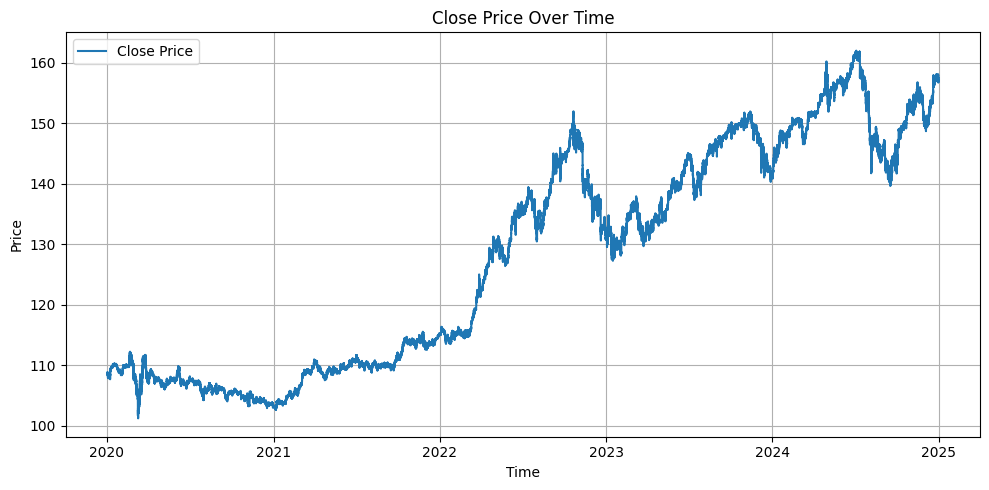

In [5]:
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df and 'timestamp' is datetime type
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['close'], label='Close Price')

plt.title('Close Price Over Time')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


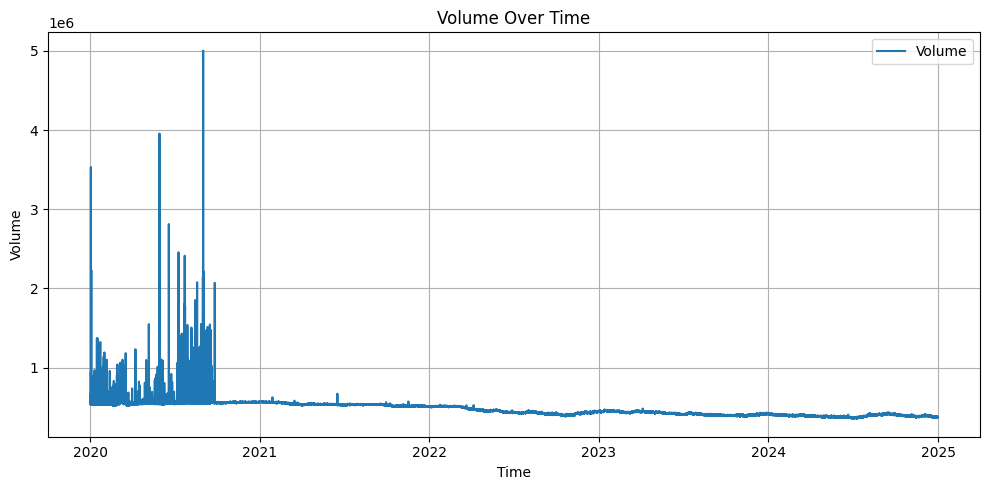

In [6]:
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df and 'timestamp' is datetime type
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['volume'], label='Volume')

plt.title('Volume Over Time')
plt.xlabel('Time')
plt.ylabel('Volume')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
df.isna().sum() / df.shape[0]

open      0.0
high      0.0
low       0.0
close     0.0
volume    0.0
spread    0.0
dtype: float64

# Volume Feature Engineering

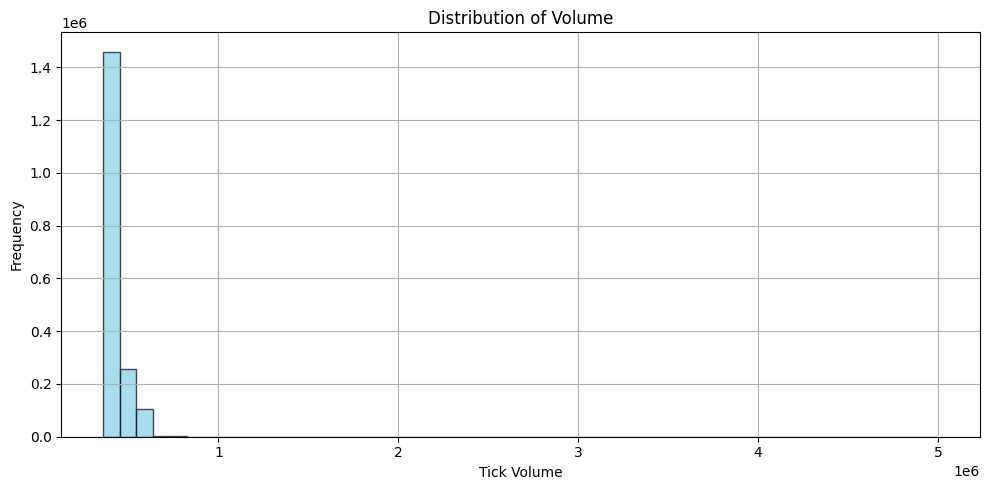

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(df['volume'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')

plt.title('Distribution of Volume')
plt.xlabel('Tick Volume')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
import numpy as np
df['log_volume'] = np.log1p(df['volume'])

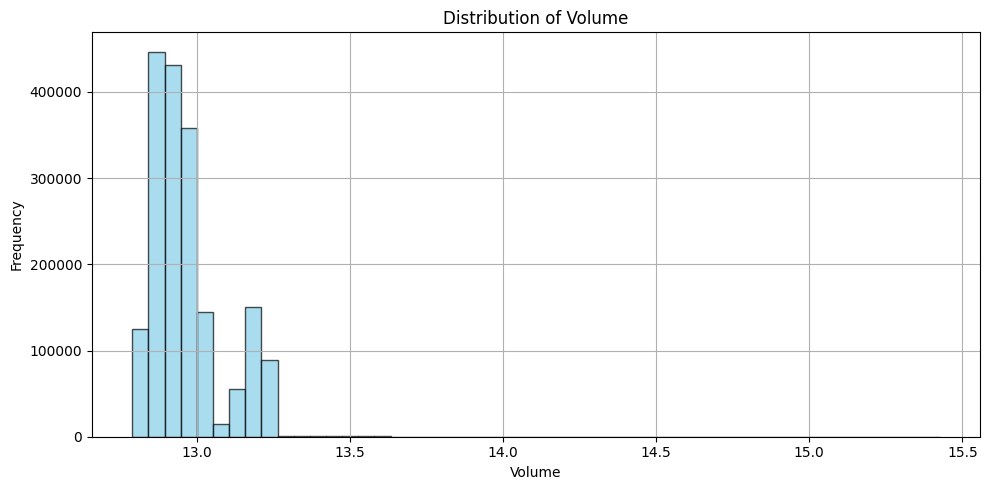

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(df['log_volume'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')

plt.title('Distribution of Volume')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


# Feature engineering

## Add delta and return

The original price data is non-stationary, we can convert it into stationary data by calculating the difference between each timeframe as *delta* value.
And we are also adding *return* values that indicates the percentage of grow/drop from the last timeframe.
We will do the following process:
1. calculate delta and returns within each timegroup, note that this will result in adding 1 NaN value for each time group and will be dropped later on.
2. labeling the moving **direction** for each row based on the **return** and a given **threshold**
    ```
    'up' if x > threshold else ('down' if x < -threshold else 'flat')
    ```
3. use a global encoder to encode the **direction**, this column will later on be used as target to train our model.

In [11]:
import pandas as pd
import numpy as np

def add_return_features(df: pd.DataFrame, price_col: str = 'close') -> pd.DataFrame:
    """
    Adds delta, simple return, and log return columns based on a single price column.

    Args:
        df (pd.DataFrame): Input DataFrame with a price column.
        price_col (str): Column name containing price values (default = 'close').

    Returns:
        pd.DataFrame: DataFrame with added columns:
            - {price_col}_delta
            - {price_col}_return
            - {price_col}_log_return
    """
    df = df.copy()
    df[f"{price_col}_delta"] = df[price_col] - df[price_col].shift(1)
    df[f"{price_col}_return"] = df[price_col] / df[price_col].shift(1) - 1
    df[f"{price_col}_log_return"] = np.log(df[price_col] / df[price_col].shift(1))

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df


In [12]:
df = add_return_features(df)

## Plot histgram

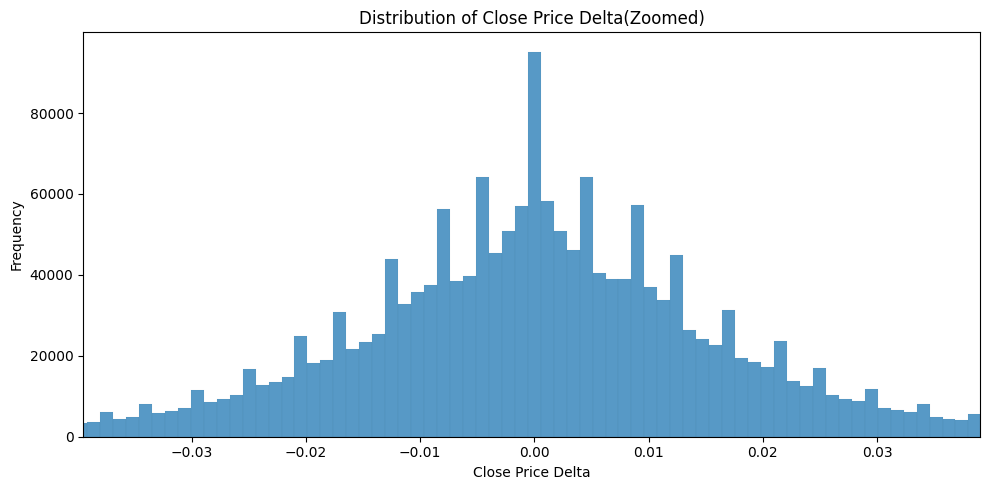

In [13]:
import seaborn as sns

df_copy = df.copy()

low, high = df_copy['close_delta'].quantile([0.025, 0.975])  # 95% range

plt.figure(figsize=(10, 5))
sns.histplot(df_copy['close_delta'])
plt.title("Distribution of Close Price Delta(Zoomed)")
plt.xlabel("Close Price Delta")
plt.ylabel("Frequency")
plt.xlim(low, high)
plt.tight_layout()
plt.show()

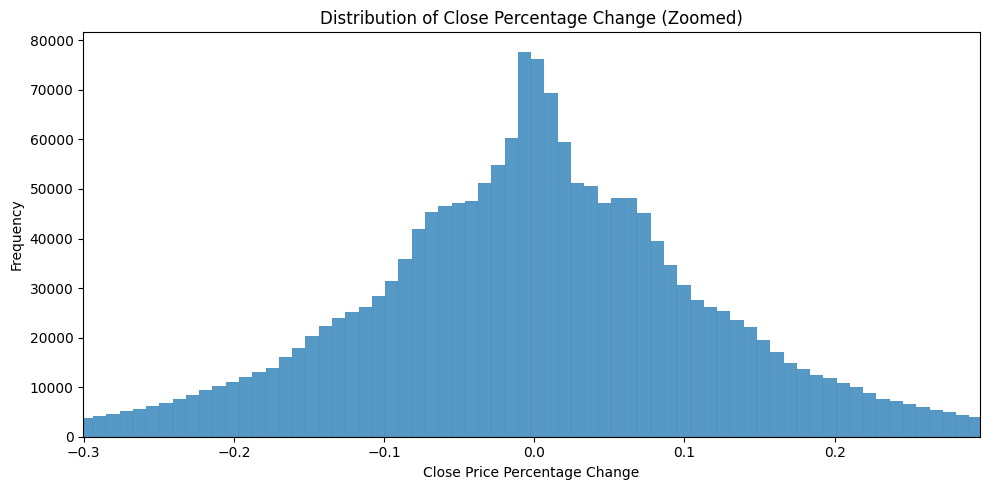

In [14]:
df_copy = df.copy()

low, high = (df_copy['close_return']*1000).quantile([0.025, 0.975])  # 95% range

plt.figure(figsize=(10, 5))
sns.histplot(df_copy['close_return']*1000)
plt.title("Distribution of Close Percentage Change (Zoomed)")
plt.xlabel("Close Price Percentage Change")
plt.ylabel("Frequency")
plt.xlim(low, high)
plt.tight_layout()
plt.show()

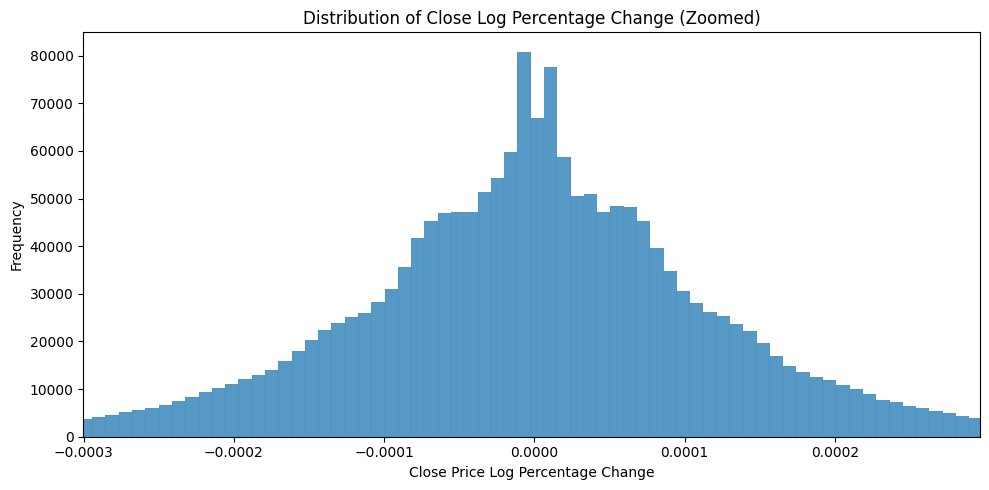

In [15]:
df_copy = df.copy()

low, high = (df_copy['close_log_return']).quantile([0.025, 0.975])  # 95% range

plt.figure(figsize=(10, 5))
sns.histplot(df_copy['close_log_return'])
plt.title("Distribution of Close Log Percentage Change (Zoomed)")
plt.xlabel("Close Price Log Percentage Change")
plt.ylabel("Frequency")
plt.xlim(low, high)
plt.tight_layout()
plt.show()

## Calculate average values

df['ma_21'] = (
    df['close']
    .rolling(window=21, min_periods=1)
    .mean()
)
df.head()

In [16]:
df['ret_mean_5'] = (
    df['close_log_return']
    .rolling(window=5, min_periods=5)
    .mean()
)
df.head()

,open,high,low,close,volume,spread,log_volume,close_delta,close_return,close_log_return,ret_mean_5
timestamp,,,,,,,,,,,
2020-01-01 22:06:51.864,108.7580,108.7700,108.7495,108.7565,534640.000865,0.027887,13.189351,NaN,NaN,NaN,NaN
2020-01-01 22:07:29.989,108.7595,108.7615,108.7510,108.7595,533939.994574,0.020597,13.188041,0.003,0.000028,0.000028,NaN
2020-01-01 22:08:54.106,108.7605,108.7645,108.7495,108.7575,535240.000248,0.022207,13.190472,-0.002,-0.000018,-0.000018,NaN
2020-01-01 22:09:47.753,108.7565,108.7625,108.7460,108.7495,535280.000806,0.032033,13.190547,-0.008,-0.000074,-0.000074,NaN
2020-01-01 22:13:29.431,108.7495,108.7600,108.6495,108.7455,534949.996591,0.024844,13.189930,-0.004,-0.000037,-0.000037,NaN


In [17]:
df['ret_mean_10'] = (
    df['close_log_return']
    .rolling(window=10, min_periods=10)
    .mean()
)
df.head()

,open,high,low,close,volume,spread,log_volume,close_delta,close_return,close_log_return,ret_mean_5,ret_mean_10
timestamp,,,,,,,,,,,,
2020-01-01 22:06:51.864,108.7580,108.7700,108.7495,108.7565,534640.000865,0.027887,13.189351,NaN,NaN,NaN,NaN,NaN
2020-01-01 22:07:29.989,108.7595,108.7615,108.7510,108.7595,533939.994574,0.020597,13.188041,0.003,0.000028,0.000028,NaN,NaN
2020-01-01 22:08:54.106,108.7605,108.7645,108.7495,108.7575,535240.000248,0.022207,13.190472,-0.002,-0.000018,-0.000018,NaN,NaN
2020-01-01 22:09:47.753,108.7565,108.7625,108.7460,108.7495,535280.000806,0.032033,13.190547,-0.008,-0.000074,-0.000074,NaN,NaN
2020-01-01 22:13:29.431,108.7495,108.7600,108.6495,108.7455,534949.996591,0.024844,13.189930,-0.004,-0.000037,-0.000037,NaN,NaN


## Drop NaN

In [18]:
df.isna().sum()

open                 0
high                 0
low                  0
close                0
volume               0
spread               0
log_volume           0
close_delta          1
close_return         1
close_log_return     1
ret_mean_5           5
ret_mean_10         10
dtype: int64

In [19]:
df = df.dropna()

In [20]:
df

,open,high,low,close,volume,spread,log_volume,close_delta,close_return,close_log_return,ret_mean_5,ret_mean_10
timestamp,,,,,,,,,,,,
2020-01-01 23:21:26.690,108.6435,108.6790,108.6435,108.6790,534460.000396,0.003709,13.189014,0.0360,0.000331,0.000331,-0.000064,-0.000071
2020-01-01 23:29:06.865,108.6790,108.7020,108.6635,108.7020,537749.999881,0.003010,13.195151,0.0230,0.000212,0.000212,0.000039,-0.000053
2020-01-01 23:36:19.371,108.7005,108.7020,108.6845,108.6880,535390.000820,0.003233,13.190753,-0.0140,-0.000129,-0.000129,-0.000003,-0.000064
2020-01-01 23:45:21.805,108.6880,108.6895,108.6760,108.6815,537089.997411,0.002859,13.193923,-0.0065,-0.000060,-0.000060,0.000117,-0.000063
2020-01-01 23:50:25.086,108.6805,108.7140,108.6800,108.7100,535309.998512,0.002339,13.190603,0.0285,0.000262,0.000262,0.000123,-0.000033
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-30 23:51:47.271,156.9865,156.9985,156.9820,156.9820,371640.002012,0.009272,12.825684,-0.0050,-0.000032,-0.000032,-0.000054,0.000009
2024-12-30 23:55:02.722,156.9785,157.0125,156.9785,157.0090,370050.000668,0.008903,12.821396,0.0270,0.000172,0.000172,-0.000029,0.000008
2024-12-30 23:57:13.562,157.0110,157.0110,156.9900,157.0070,372599.998236,0.010955,12.828263,-0.0020,-0.000013,-0.000013,-0.000030,0.000001


# Saving the file

In [21]:
df.to_pickle(PROCESSED_FILE_PATH)